In [2]:
import pandas as pd
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from shapely.geometry import Point
import geopandas as gpd
from geodatasets import get_path
import seaborn as sns
import fiona
from shapely import wkt

ASBPA Data

In [5]:
asbpa = pd.read_csv('data/ASBPA.csv')
asbpa_clean = asbpa.rename({'Project Name': 'Beach_location', 
                      'Sand Source Name': 'Sand_source_name', 
                      'Sand Source Type': 'Sand_source_type', 
                      'Sand Source Location': 'Sand_source_location',
                      'Length (ft)': 'Length_ft', 
                      'Volume (cy)': 'Volume_cy'}, axis = 1)
asbpa_clean = asbpa_clean.drop(['Project Type', 'RSM'], axis = 1)
#asbpa_clean.to_csv('data/asbpa_clean.csv', index = False)

In [6]:
#asbpa_clean

In [13]:
asbpa_states = asbpa
asbpa_states = asbpa_states.drop(['Latitude', 'Longitude', 'Project Name', 'Project Type', 'Sand Source Location', 'Sand Source Name', 'Sand Source Type', 'RSM'], axis = 1)
asbpa_states['Year'] = asbpa_states['Year'].replace({'1951-57': '1951', '1959\n': '1959', '2018/2019': '2018'})

In [14]:
asbpa_states.query('State=="NJ"')

,State,Year,Length (ft),Volume (cy)
2828,NJ,1947,0.0,150000.0
2829,NJ,1949,0.0,16000.0
2830,NJ,1950,0.0,22000.0
2831,NJ,1958,0.0,250000.0
2832,NJ,1960,0.0,250000.0
...,...,...,...,...
3119,NJ,1966,0.0,10000.0
3120,NJ,1963,0.0,25000.0
3121,NJ,1966,0.0,5000.0
3122,NJ,1989,0.0,190000.0


In [16]:
asbpa_states['Year'] = asbpa_states['Year'].astype(int)

ValueError: invalid literal for int() with base 10: 'Pre-1961'

In [17]:
asbpa_states.to_csv("data/asbpa_states.csv", index=False)
asbpa_states

,State,Year,Length (ft),Volume (cy)
0,AK,2010,NaN,12296.0
1,AK,2010,NaN,25965.0
2,AK,2011,NaN,34109.0
3,AK,2013,NaN,20570.0
4,AK,2014,NaN,54283.0
...,...,...,...,...
3624,WI,1991,NaN,46577.0
3625,WI,1997,NaN,49035.0
3626,WI,2000,NaN,41072.0
3627,WI,2005,NaN,43189.0


In [9]:
grouped_asbpa_states = asbpa_states.groupby(['State','Year'])[['Length (ft)', 'Volume (cy)']].sum()
grouped_asbpa_states = grouped_asbpa_states.reset_index()
grouped_asbpa_states.to_csv("data/grouped_asbpa_states.csv", index=True)

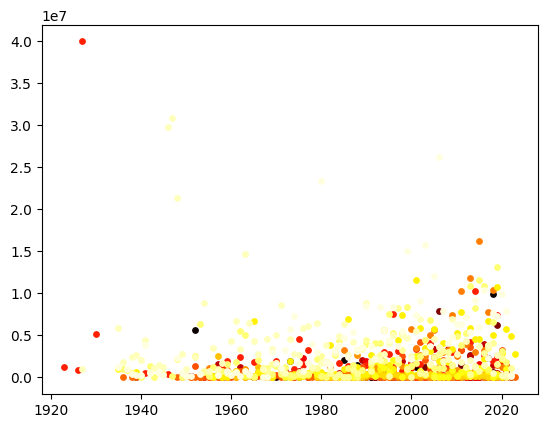

In [10]:
x = grouped_asbpa_states['Year']
y = grouped_asbpa_states['Volume (cy)']
uniq = list(set(grouped_asbpa_states['State']))
z = range(1, len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

for i in range(len(uniq)):
    indx = grouped_asbpa_states['State'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    


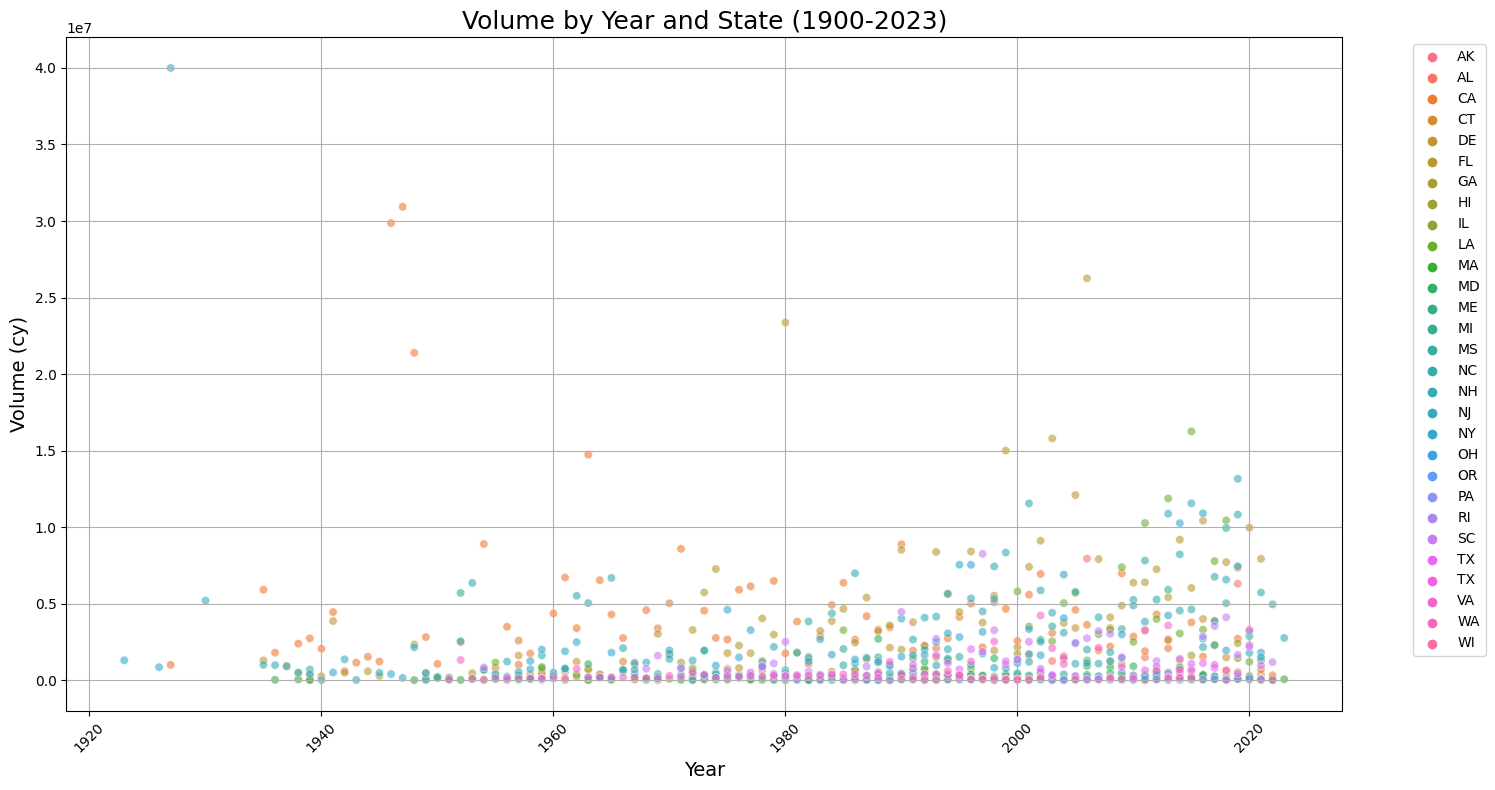

In [11]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=grouped_asbpa_states, x='Year', y='Volume (cy)', hue='State', alpha=0.6)
plt.title('Volume by Year and State (1900-2023)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Volume (cy)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('images/asbpa_us_scatter.png', dpi=300)

plt.show()

In [12]:
asbpa_us = asbpa_states.groupby('Year')[['Length (ft)', 'Volume (cy)']].sum()

In [13]:
asbpa_us['Year'].unique()
asbpa_us['Year'] = asbpa_us['Year'].replace({'1951-57': '1951', '1959\n': '1959', '2018/2019': '2018'})
asbpa_us = asbpa_us.groupby('Year').sum().reset_index()

KeyError: 'Year'

In [ ]:
asbpa_us.to_csv("data/asbpa_us.csv", index=True)

In [ ]:
asbpa_us = asbpa_us.reset_index()

In [ ]:
plt.figure(figsize = (18,7))
plt.plot(asbpa_us['Year'], asbpa_us['Volume (cy)'], marker = 'o', linestyle = '-', color = 'blue')
plt.title('Volume by Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Volume (cy)', fontsize=15)
plt.xticks(rotation=45)  # Rotate the x-axis labels to prevent overlap
plt.yticks(fontsize=12)
plt.grid(True)

plt.xlim(asbpa_us['Year'].min(), asbpa_us['Year'].max())
plt.tight_layout()
plt.savefig('images/asbpa_us_cumulative.png', dpi=300)
plt.show()

# Sites

In [3]:
sites = pd.read_csv('data/sites_data.csv')

In [4]:
sites = gpd.GeoDataFrame(
    sites, geometry = gpd.points_from_xy(sites.siteLongitude, sites. siteLatitude), crs = "EPSG: 4269")
sites.head(2)

,Unnamed: 0,id,siteLatitude,siteLongitude,location,city,stateOrTerritory,siteFeatureType,toeHeight,crestHeight,...,distanceBetweenSiteAndForecast,beachSlope,maxPredictedImpact,maxPredictedImpactCode,predictedDurationOfCollision,predictedDurationOfOverwash,predictedDurationOfInundation,region_id,forecast_id,geometry
0,0,1450,41.3285,-70.819,Gay Head Town Beach,Chilmark,MA,Dune,2.99,7.00,...,896,0.156,NaN,0,0,0,0,1,72261,POINT (-70.81900 41.32850)
1,1,1451,41.3224,-70.812,Long Beach,Chilmark,MA,Cliff,3.10,7.31,...,0,0.156,NaN,0,0,0,0,1,72261,POINT (-70.81200 41.32240)


In [ ]:
site_id = sites['id']
region_id = sites['region_id']
forecast_id = sites['forecast_id']
site_latitude = sites['siteLatitude']
site_longitude = sites['siteLongitude']

In [ ]:
water_api = pd.DataFrame()
water_api = pd.concat([water_api, site_id], axis = 1)
water_api = pd.concat([water_api, region_id], axis = 1)
water_api = pd.concat([water_api, forecast_id], axis = 1)
water_api = pd.concat([water_api, site_latitude], axis = 1)
water_api = pd.concat([water_api, site_longitude], axis = 1)

In [5]:
sites = sites.rename({'stateOrTerritory': 'State', 'location': 'Beachloc'}, axis = 1)

In [6]:
sites.drop(['Unnamed: 0','dateElevationMeasured', 'region_id', 'forecast_id', 'dataReleaseUrl'], axis = 1, inplace = True)

In [7]:
sites.head(2)

,id,siteLatitude,siteLongitude,Beachloc,city,State,siteFeatureType,toeHeight,crestHeight,forecastLatitude,forecastLongitude,distanceBetweenSiteAndForecast,beachSlope,maxPredictedImpact,maxPredictedImpactCode,predictedDurationOfCollision,predictedDurationOfOverwash,predictedDurationOfInundation,geometry
0,1450,41.3285,-70.819,Gay Head Town Beach,Chilmark,MA,Dune,2.99,7.00,41.3224,-70.812,896,0.156,NaN,0,0,0,0,POINT (-70.81900 41.32850)
1,1451,41.3224,-70.812,Long Beach,Chilmark,MA,Cliff,3.10,7.31,41.3224,-70.812,0,0.156,NaN,0,0,0,0,POINT (-70.81200 41.32240)


In [8]:
sites = sites.rename({'siteLatitude': 'sLatitude',
                     'siteLongitude': 'sLongitude',
                     'siteFeatureType': 'Feature'}, axis = 1)

In [9]:
sites.drop(['forecastLatitude', 'forecastLongitude', 'distanceBetweenSiteAndForecast', 'maxPredictedImpact', 'maxPredictedImpactCode', 'predictedDurationOfCollision', 'predictedDurationOfOverwash', 'predictedDurationOfInundation'], axis = 1, inplace = True)

In [10]:
sites.columns = [x.lower() for x in sites.columns]

In [12]:
sites.to_file('sites_id/sites_id.shp', mode = 'w')

/tmp/ipykernel_450/2980669657.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sites.to_file('sites_id/sites_id.shp', mode = 'w')


States_geometry

In [333]:
gdf = pd.read_csv('data/states_geometry.csv')

In [11]:
sites.head(5)

,id,slatitude,slongitude,beachloc,city,state,feature,toeheight,crestheight,beachslope,geometry
0,1450,41.3285,-70.819,Gay Head Town Beach,Chilmark,MA,Dune,2.99,7.00,0.1560,POINT (-70.81900 41.32850)
1,1451,41.3224,-70.812,Long Beach,Chilmark,MA,Cliff,3.10,7.31,0.1560,POINT (-70.81200 41.32240)
2,1452,41.3195,-70.807,Long Beach,Chilmark,MA,Dune,3.49,7.14,0.0950,POINT (-70.80700 41.31950)
3,1453,41.3114,-70.794,Squibnocket Marshes,Chilmark,MA,Dune,3.34,7.42,0.0874,POINT (-70.79400 41.31140)
4,1454,41.3021,-70.778,Squibnocket Point,Chilmark,MA,Dune,2.70,7.29,0.1102,POINT (-70.77800 41.30210)


In [334]:
gdf_clean = gdf.drop(['Unnamed: 0', 'STATEFP', 'STATENS', 'AFFGEOID', 'AWATER', 'LSAD', 'ALAND'], axis = 1)
gdf_clean.rename({'STUSPS': 'State'}, axis=1, inplace=True)
gdf_clean.rename({'NAME': 'Name'}, axis=1, inplace=True)

In [335]:
new_column_order = ['State'] + ['Name'] + ['GEOID'] + ['geometry']
gdf_clean = gdf_clean[new_column_order]

In [336]:
gdf_clean = gdf_clean[(gdf_clean.State != 'PR') & (gdf_clean.State != 'GU') & (gdf_clean.State != 'VI') & (gdf_clean.State != 'AS') & (gdf_clean.State != 'MP')]
gdf_clean = gdf_clean.rename({'GEOID': 'State_id'}, axis = 1)

In [332]:
gdf_clean.to_csv("data/gdf_clean.csv", index=False)

In [337]:
gdf_clean['geometry'] = gdf_clean['geometry'].apply(wkt.loads)
gdf_geo = gpd.GeoDataFrame(gdf_clean, geometry='geometry')
gdf_geo.crs = "EPSG:4269"
gdf_geo.head(2)

,State,Name,State_id,geometry
0,MS,Mississippi,28,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,NC,North Carolina,37,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [339]:
gdf_geo.to_file('states/states_id.shp', index = False)

In [8]:
df.head(2)

,id,siteLatitude,siteLongitude,Beach_location,city,State,siteFeatureType,toeHeight,crestHeight,forecastLatitude,forecastLongitude,distanceBetweenSiteAndForecast,beachSlope,maxPredictedImpact,maxPredictedImpactCode,predictedDurationOfCollision,predictedDurationOfOverwash,predictedDurationOfInundation,geometry
0,1450,41.3285,-70.819,Gay Head Town Beach,Chilmark,MA,Dune,2.99,7.00,41.3224,-70.812,896,0.156,NaN,0,0,0,0,POINT (-70.819 41.3285)
1,1451,41.3224,-70.812,Long Beach,Chilmark,MA,Cliff,3.10,7.31,41.3224,-70.812,0,0.156,NaN,0,0,0,0,POINT (-70.812 41.3224)


In [20]:
asc

,State,Beach_location,Year,Length_ft,Volume_cy,Sand_source_name,Sand_source_location,Sand_source_type,Latitude,Longitude
0,AK,Ninilchik,2010,NaN,12296.0,NaN,NaN,Nearshore,60.018889,-151.587500
1,AK,Nome Harbor,2010,NaN,25965.0,NaN,NaN,Nearshore,64.497778,-165.431389
2,AK,Nome Harbor,2011,NaN,34109.0,NaN,NaN,Nearshore,64.497778,-165.431389
3,AK,Nome Harbor,2013,NaN,20570.0,NaN,NaN,Nearshore,64.497778,-165.431389
4,AK,Nome Harbor,2014,NaN,54283.0,NaN,NaN,Nearshore,64.497778,-165.431389
...,...,...,...,...,...,...,...,...,...,...
3617,WI,"SHEBOYGAN HARBOR, WI",1991,NaN,46577.0,"SHEBOYGAN HARBOR, WI",NaN,Nearshore,43.750000,-87.704167
3618,WI,"TWO RIVERS HARBOR, WI",1997,NaN,49035.0,"TWO RIVERS HARBOR, WI",NaN,Nearshore,44.141667,-87.587500
3619,WI,"TWO RIVERS HARBOR, WI",2000,NaN,41072.0,"TWO RIVERS HARBOR, WI",NaN,Nearshore,44.141667,-87.587500
3620,WI,"TWO RIVERS HARBOR, WI",2005,NaN,43189.0,"TWO RIVERS HARBOR, WI",NaN,Nearshore,44.141667,-87.587500


# Mapping GEO ID to Sites

In [222]:
#asc = pd.read_csv('data/asbpa_clean.csv')

df = gpd.read_file('sites/sites_updated.shp')
#test = df.dropna(subset=['Beach_location'])
#test
df.head(2)

,id,sLatitude,sLongitude,Beachloc,city,State,Feature,toeHeight,crestHeigh,beachSlope,geometry
0,1450,41.3285,-70.819,Gay Head Town Beach,Chilmark,MA,Dune,2.99,7.00,0.156,POINT (-70.81900 41.32850)
1,1451,41.3224,-70.812,Long Beach,Chilmark,MA,Cliff,3.10,7.31,0.156,POINT (-70.81200 41.32240)


In [212]:
df = gpd.read_file('sites/sites_updated.shp')
df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [213]:
counties = gpd.read_file('counties/county_us.shp')
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [227]:
merged_df = gpd.sjoin(df, counties, how="inner", predicate='intersects')
merged_df.drop(['id', 'State_right', 'index_right', 'GEOID'], axis = 1, inplace = True)
merged_df = merged_df.rename({'State_left': 'State'}, axis = 1)

In [230]:
columns = ['GEO_ID'] + [col for col in merged_df.columns if col != 'GEO_ID']

# Reindex the DataFrame with the new column order
merged_df = merged_df[columns]

merged_df.to_file('sites_id/sites_id.shp')

In [288]:
merged_df.dtypes

GEO_ID          object
sLatitude      float64
sLongitude     float64
Beachloc        object
city            object
State           object
Feature         object
toeHeight      float64
crestHeigh     float64
beachSlope     float64
geometry      geometry
Countyname      object
LSAD            object
Censusarea     float64
Name            object
dtype: object

# Mapping GEO ID to asbpa_clean

In [257]:
asbpa = pd.read_csv('data/asbpa_clean.csv')
asbpa = asbpa.rename({'Beach_location': 'Beachloc',
                     'Sand_source_name': 'ssname',
                     'Sand_source_location': 'ssloc',
                     'Sand_source_type': 'sstype'}, axis = 1)

In [272]:
asbpa_edit = asbpa.drop(['Year', 'Length_ft', 'Volume_cy', 'ssname', 'ssloc', 'sstype'], axis = 1)
asbpa_edit = asbpa_edit.drop_duplicates()

In [274]:
gdf = gpd.GeoDataFrame(
    asbpa_edit, geometry = gpd.points_from_xy(asbpa_edit.Longitude, asbpa_edit.Latitude), crs = "EPSG: 4269")
gdf

,State,Beachloc,Latitude,Longitude,geometry
0,AK,Ninilchik,60.018889,-151.587500,POINT (-151.58750 60.01889)
1,AK,Nome Harbor,64.497778,-165.431389,POINT (-165.43139 64.49778)
12,AL,Dauphin Island,30.241569,-88.112033,POINT (-88.11203 30.24157)
13,AL,Dauphin Island East End - Beach Nourishment,30.246325,-88.082167,POINT (-88.08217 30.24632)
14,AL,Gulf Shores,30.245021,-87.700574,POINT (-87.70057 30.24502)
...,...,...,...,...,...
3603,WI,DULUTH-SUPERIOR HBR MN & WI,46.737500,-92.066667,POINT (-92.06667 46.73750)
3611,WI,"KENOSHA HARBOR, WI",42.583333,-87.808333,POINT (-87.80833 42.58333)
3612,WI,"PORT WING HARBOR, WI",46.791667,-91.387500,POINT (-91.38750 46.79167)
3617,WI,"SHEBOYGAN HARBOR, WI",43.750000,-87.704167,POINT (-87.70417 43.75000)


In [280]:
merged2 = gpd.sjoin_nearest(counties, gdf, how="right")
merged2.head(2)

/usr/local/lib/python3.9/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,index_left,GEO_ID,Countyname,LSAD,Censusarea,Name,State_left,GEOID,State_right,Beachloc,Latitude,Longitude,geometry
0,69.0,0500000US02122,Kenai Peninsula,Borough,16075.331,Alaska,AK,2.0,AK,Ninilchik,60.018889,-151.587500,POINT (-151.58750 60.01889)
1,72.0,0500000US02180,Nome,CA,22961.761,Alaska,AK,2.0,AK,Nome Harbor,64.497778,-165.431389,POINT (-165.43139 64.49778)


In [282]:
merged2 = merged2.drop(['index_left', 'State_right'], axis = 1)

In [285]:
merged2

,GEO_ID,Countyname,LSAD,Censusarea,Name,State,GEOID,Beachloc,Latitude,Longitude,geometry
0,0500000US02122,Kenai Peninsula,Borough,16075.331,Alaska,AK,2.0,Ninilchik,60.018889,-151.587500,POINT (-151.58750 60.01889)
1,0500000US02180,Nome,CA,22961.761,Alaska,AK,2.0,Nome Harbor,64.497778,-165.431389,POINT (-165.43139 64.49778)
12,0500000US01097,Mobile,County,1229.435,Alabama,AL,1.0,Dauphin Island,30.241569,-88.112033,POINT (-88.11203 30.24157)
13,0500000US01097,Mobile,County,1229.435,Alabama,AL,1.0,Dauphin Island East End - Beach Nourishment,30.246325,-88.082167,POINT (-88.08217 30.24632)
14,0500000US01003,Baldwin,County,1589.784,Alabama,AL,1.0,Gulf Shores,30.245021,-87.700574,POINT (-87.70057 30.24502)
...,...,...,...,...,...,...,...,...,...,...,...
3603,0500000US27137,St. Louis,County,6247.401,Minnesota,MN,27.0,DULUTH-SUPERIOR HBR MN & WI,46.737500,-92.066667,POINT (-92.06667 46.73750)
3611,0500000US55059,Kenosha,County,271.990,Wisconsin,WI,55.0,"KENOSHA HARBOR, WI",42.583333,-87.808333,POINT (-87.80833 42.58333)
3612,0500000US55007,Bayfield,County,1477.863,Wisconsin,WI,55.0,"PORT WING HARBOR, WI",46.791667,-91.387500,POINT (-91.38750 46.79167)
3617,0500000US55117,Sheboygan,County,511.265,Wisconsin,WI,55.0,"SHEBOYGAN HARBOR, WI",43.750000,-87.704167,POINT (-87.70417 43.75000)


In [289]:
merged2 = merged2.rename({'State_left': "State"}, axis = 1)
merged2.drop(['GEOID'], axis = 1, inplace = True)
merged2.to_file('asbpa_id/asbpa_id.shp')

In [290]:
merged2.head(2)

,GEO_ID,Countyname,LSAD,Censusarea,Name,State,Beachloc,Latitude,Longitude,geometry
0,0500000US02122,Kenai Peninsula,Borough,16075.331,Alaska,AK,Ninilchik,60.018889,-151.587500,POINT (-151.58750 60.01889)
1,0500000US02180,Nome,CA,22961.761,Alaska,AK,Nome Harbor,64.497778,-165.431389,POINT (-165.43139 64.49778)


# Connected asbpa_id to asbpa_info

In [296]:
asbpa = pd.read_csv('data/asbpa_clean.csv')
asbpa = asbpa.rename({'Beach_location': 'Beachloc',
                     'Sand_source_name': 'ssname',
                     'Sand_source_location': 'ssloc',
                     'Sand_source_type': 'sstype'}, axis = 1)
gdf = gpd.GeoDataFrame(
    asbpa, geometry = gpd.points_from_xy(asbpa.Longitude, asbpa.Latitude), crs = "EPSG: 4269")

In [302]:
joined = merged2.sjoin(gdf, how = "inner", predicate = 'contains')

In [304]:
joined.T

,0,1,1,1,1,1,1,1,1,1,...,3612,3612,3612,3612,3612,3617,3618,3618,3618,3618
GEO_ID,0500000US02122,0500000US02180,0500000US02180,0500000US02180,0500000US02180,0500000US02180,0500000US02180,0500000US02180,0500000US02180,0500000US02180,...,0500000US55007,0500000US55007,0500000US55007,0500000US55007,0500000US55007,0500000US55117,0500000US55071,0500000US55071,0500000US55071,0500000US55071
Countyname,Kenai Peninsula,Nome,Nome,Nome,Nome,Nome,Nome,Nome,Nome,Nome,...,Bayfield,Bayfield,Bayfield,Bayfield,Bayfield,Sheboygan,Manitowoc,Manitowoc,Manitowoc,Manitowoc
LSAD,Borough,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,County,County,County,County,County,County,County,County,County,County
Censusarea,16075.331,22961.761,22961.761,22961.761,22961.761,22961.761,22961.761,22961.761,22961.761,22961.761,...,1477.863,1477.863,1477.863,1477.863,1477.863,511.265,589.082,589.082,589.082,589.082
Name,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,Alaska,...,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin
State_left,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
Beachloc_left,Ninilchik,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,Nome Harbor,...,"PORT WING HARBOR, WI","PORT WING HARBOR, WI","PORT WING HARBOR, WI","PORT WING HARBOR, WI","PORT WING HARBOR, WI","SHEBOYGAN HARBOR, WI","TWO RIVERS HARBOR, WI","TWO RIVERS HARBOR, WI","TWO RIVERS HARBOR, WI","TWO RIVERS HARBOR, WI"
Latitude_left,60.018889,64.497778,64.497778,64.497778,64.497778,64.497778,64.497778,64.497778,64.497778,64.497778,...,46.791667,46.791667,46.791667,46.791667,46.791667,43.75,44.141667,44.141667,44.141667,44.141667
Longitude_left,-151.5875,-165.431389,-165.431389,-165.431389,-165.431389,-165.431389,-165.431389,-165.431389,-165.431389,-165.431389,...,-91.3875,-91.3875,-91.3875,-91.3875,-91.3875,-87.704167,-87.5875,-87.5875,-87.5875,-87.5875
geometry,POINT (-151.5875 60.01888889),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),POINT (-165.4313889 64.49777778),...,POINT (-91.3875 46.79166667),POINT (-91.3875 46.79166667),POINT (-91.3875 46.79166667),POINT (-91.3875 46.79166667),POINT (-91.3875 46.79166667),POINT (-87.70416667 43.75),POINT (-87.5875 44.14166667),POINT (-87.5875 44.14166667),POINT (-87.5875 44.14166667),POINT (-87.5875 44.14166667)


In [305]:
joined.drop(['Latitude_right', 'Longitude_right', 'Beachloc_right', 'State_right', 'index_right'], axis = 1, inplace = True)
joined = joined.rename({'State_left': 'State', 
                       'Beachloc_left': 'Beachloc',
                       'Latitude_left': 'Latitude',
                       'Longitude_left': 'Longitude'}, axis = 1)
joined.head(2)

,GEO_ID,Countyname,LSAD,Censusarea,Name,State,Beachloc,Latitude,Longitude,geometry,Year,Length_ft,Volume_cy,ssname,ssloc,sstype
0,0500000US02122,Kenai Peninsula,Borough,16075.331,Alaska,AK,Ninilchik,60.018889,-151.587500,POINT (-151.58750 60.01889),2010,NaN,12296.0,NaN,NaN,Nearshore
1,0500000US02180,Nome,CA,22961.761,Alaska,AK,Nome Harbor,64.497778,-165.431389,POINT (-165.43139 64.49778),2010,NaN,25965.0,NaN,NaN,Nearshore


In [306]:
joined.to_file('asbpa_info/asbpa_info.shp')

In [307]:
joined.dtypes

GEO_ID          object
Countyname      object
LSAD            object
Censusarea     float64
Name            object
State           object
Beachloc        object
Latitude       float64
Longitude      float64
geometry      geometry
Year             int64
Length_ft      float64
Volume_cy      float64
ssname          object
ssloc           object
sstype          object
dtype: object